In [1]:
import numpy as np
from qiskit import IBMQ

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')

In [3]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>,
 <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>]

In [4]:
backend = provider.get_backend('ibmq_qasm_simulator')

In [23]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.transformers.second_quantization.electronic.freeze_core_transformer import FreezeCoreTransformer

Originally, we have these orbitals, H: 1s2, Li: 1s2, 2s2, 2px2, 2py2, 2pz2, total (spin) oribtals: 6 (12)

To reduce number of qubits, we align the H and Li atom to Z axis so that there is no contribution of px (orbital 3) and py (orbital 4).

Also, we freeze the core electrons so that 2 electrons from Li are occupied in the 1s2 (orbital 0).

Ref: https://arxiv.org/abs/1704.05018

In [24]:
# Cartesians from:
# https://cccbdb.nist.gov/exp2x.asp?casno=7580678&charge=0
molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 1.5949]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

# FreezeCoreTransformer will freeze core electrons by defaults
es_problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(remove_orbitals=[3, 4])])
qubit_converter = QubitConverter(ParityMapper(), True, [1, 1])

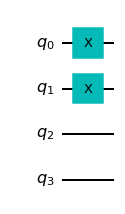

In [25]:
from qiskit_nature.circuit.library import HartreeFock

# strange behavior
# we need to convert second_q_ops first to make 4-qubit init_state
second_q_ops = es_problem.second_q_ops()
qubit_op = qubit_converter.convert(second_q_ops[0])

init_state = HartreeFock(es_problem.num_spin_orbitals, es_problem.num_particles, qubit_converter)
init_state.draw()

In [26]:
from qiskit_nature.circuit.library import UCCSD

ansatz = UCCSD(qubit_converter, es_problem.num_particles, es_problem.num_spin_orbitals, 1, init_state)

In [27]:
np.random.seed(5)
initial_point = np.random.random(ansatz.num_parameters)

In [28]:
from qiskit_nature.runtime import VQEClient

optimizer = {
    'name': 'QN-SPSA',
    #'name': 'SPSA',
    'maxiter': 100,
    "resamplings": {1: 100},
}
    
runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         backend=backend,
                         initial_point=initial_point,
                         provider=provider,
                         shots=1024,
                         measurement_error_mitigation=False)

In [29]:
from qiskit_nature.algorithms import GroundStateEigensolver

runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
#runtime_vqe_result = runtime_vqe_groundstate_solver.solve(es_problem)

In [30]:
from qiskit_nature.algorithms import QEOM#, ExcitedStatesEigensolver

runtime_qeom_excited_states_calculation = QEOM(runtime_vqe_groundstate_solver, "sd")
runtime_qeom_results = runtime_qeom_excited_states_calculation.solve(es_problem)

Traceback (most recent call last):
  Input In [30] in <module>
    runtime_qeom_results = runtime_qeom_excited_states_calculation.solve(es_problem)
  File /opt/conda/lib/python3.8/site-packages/qiskit_nature/algorithms/excited_states_solvers/qeom.py:106 in solve
    groundstate_result = self._gsc.solve(problem, aux_operators)
  File /opt/conda/lib/python3.8/site-packages/qiskit_nature/algorithms/ground_state_solvers/ground_state_eigensolver.py:144 in solve
    raw_mes_result = self._solver.compute_minimum_eigenvalue(main_operator, aux_ops)
  File /opt/conda/lib/python3.8/site-packages/qiskit_nature/runtime/vqe_client.py:294 in compute_minimum_eigenvalue
    vqe_result.cost_function_evals = result.get("cost_function_evals", None)
AttributeError: 'str' object has no attribute 'get'

Use %tb to get the full traceback.


In [31]:
job = provider.runtime.job("c8c7do1897csue4rqnig")

In [32]:
job_result = job.result()

In [33]:
type(job_result)

str